# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import pandas as pd
import plotly.graph_objects as go


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data preprocessing

In [2]:
# make df with column names year, month, decimal date, SSN, M1, M2, M3, M4, M5 from file 5c_obs_sim_v1.dat
df = pd.read_csv('5c_obs_sim_v1.dat', sep='\s+', header=None, names=['year', 'month', 'decimal_date', 'SSN', 'M1', 'M2', 'M3', 'M4', 'M5'])

# normalize data to be between 0 and 1 using max value from SSN
M = df['SSN'].max()
df['SSN'] = df['SSN'] / M
for i in range(1, 6):
    df[f'M{i}'] = df[f'M{i}'] / M

df.head()

,year,month,decimal_date,SSN,M1,M2,M3,M4,M5
0,1965,1,1965.042,0.073851,0.0,0.0,0.0,0.004615,0.000511
1,1965,2,1965.123,0.075998,0.0,0.0,0.0,0.005838,0.001198
2,1965,3,1965.204,0.079004,0.0,0.0,0.0,0.007768,0.001380
3,1965,4,1965.288,0.085444,0.0,0.0,0.0,0.010287,0.001755
4,1965,5,1965.371,0.091026,0.0,0.0,0.0,0.013512,0.002240


In [3]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=df['decimal_date'], y=df['SSN'], name='SSN'))

for i in range(1, 6):
    fig.add_trace(go.Scatter(x=df['decimal_date'], y=df[f'M{i}'], name=f'M{i}', visible=True))

fig.update_yaxes(range=[-0.2, 1])
fig.show()

In [4]:
MODEL_SERIES_INPUT_SIZE = 4
OBSERVED_SERIES_INPUT_SIZE = 4

class MixedDataGenerator:
    def __init__(self,
                 model_series,
                 observed_series,
                 model_series_input_size=MODEL_SERIES_INPUT_SIZE,
                 observed_series_input_size=OBSERVED_SERIES_INPUT_SIZE):
        self.model_series = model_series
        self.observed_series = observed_series
        self.model_series_input_size = model_series_input_size
        self.observed_series_input_size = observed_series_input_size
        self.X, self.y = self._prepare_data()
        
    def _prepare_data(self):
        l = len(self.model_series) - self.model_series_input_size - self.observed_series_input_size
        X = np.zeros((l, self.model_series_input_size + self.observed_series_input_size))
        y = np.zeros(l)
        for i in range(l):
            X[i, :self.model_series_input_size] = self.model_series[i+1:i+1 + self.model_series_input_size]
            X[i, self.model_series_input_size:] = self.observed_series[i:i + self.observed_series_input_size]
            y[i] = self.observed_series[i + max(self.model_series_input_size, self.observed_series_input_size)]
        return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [5]:
model_series = df['M1'].values
observed_series = df['SSN'].values

model_series = torch.tensor(model_series, dtype=torch.float32)
observed_series = torch.tensor(observed_series, dtype=torch.float32)

data = MixedDataGenerator(model_series, observed_series)

In [6]:
train_data_X, test_data_X, train_data_y, test_data_y = train_test_split(data.X, data.y, test_size=0.4, shuffle=False)
val_data_X, test_data_X, val_data_y, test_data_y = train_test_split(test_data_X, test_data_y, test_size=0.5, shuffle=False)

trainloader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(train_data_X, train_data_y), batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(val_data_X, val_data_y), batch_size=64, shuffle=False)

# Model building

In [7]:
class NARX(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NARX, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.Softplus(),
            nn.Linear(hidden_size, output_size), 
            nn.Softplus()
        )

    def forward(self, x):
        out = self.net(x)
        return out
    
    def train_model(self, trainloader, valloader, epochs=100, lr=0.001):
        optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        criterion = nn.MSELoss()
        train_losses = []
        val_losses = []
        for _ in tqdm(range(epochs), desc='Training', unit='epoch'):
            self.train()
            train_loss = 0
            for X, y in trainloader:
                X, y = X.to(device), y.to(device)
                optimizer.zero_grad()
                output = self(X)
                loss = criterion(output, y.unsqueeze(1))
                loss.backward()
                optimizer.step()
                train_loss += loss.item()
            train_losses.append(train_loss / len(trainloader))
            self.eval()
            val_loss = 0
            with torch.no_grad():
                for X, y in valloader:
                    X, y = X.to(device), y.to(device)
                    output = self(X)
                    loss = criterion(output, y.unsqueeze(1))
                    val_loss += loss.item()
                val_losses.append(val_loss / len(valloader))
        return train_losses, val_losses

    def autoregressive_prediction(self, data):
        preds = []
        self.eval()
        X = data[0]
        for i in range(len(data) - 1):
            with torch.no_grad():
                pred = self(X.to(device))
                preds.append(pred.item())
                model_s = data[i + 1, :MODEL_SERIES_INPUT_SIZE]
                obs_s = X[MODEL_SERIES_INPUT_SIZE + 1:]
                obs_s = torch.cat((obs_s, pred))
                X = torch.cat((model_s, obs_s))
        return preds
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
model = NARX(input_size=MODEL_SERIES_INPUT_SIZE + OBSERVED_SERIES_INPUT_SIZE, hidden_size=24, output_size=1)
model.to(device)

NARX(
  (net): Sequential(
    (0): Linear(in_features=8, out_features=24, bias=True)
    (1): Softplus(beta=1, threshold=20)
    (2): Linear(in_features=24, out_features=1, bias=True)
    (3): Softplus(beta=1, threshold=20)
  )
)

# Training

In [9]:
train_losses, val_losses = model.train_model(trainloader, valloader, epochs=10000, lr=0.001)

Training: 100%|██████████| 10000/10000 [03:04<00:00, 54.34epoch/s]


In [ ]:
# load model
model.load_state_dict(torch.load('narx_model.pth'))

<All keys matched successfully>

In [ ]:
# save model
torch.save(model.state_dict(), 'narx_model.pth')

In [10]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=np.arange(len(train_losses)), y=train_losses, mode='lines', name='Train Loss'))
fig.add_trace(go.Scatter(x=np.arange(len(val_losses)), y=val_losses, mode='lines', name='Validation Loss'))
fig.update_layout(title='Training and Validation Loss', xaxis_title='Epoch', yaxis_title='Loss')
fig.show()


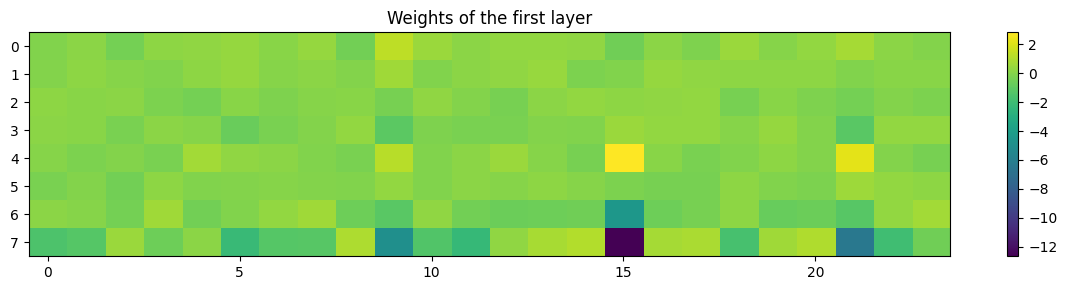

In [11]:
# plot weights of first layer as 2D image
plt.figure(figsize=(12, 3))
plt.imshow(model.net[0].weight.detach().cpu().numpy().T, aspect='auto')
plt.colorbar()
plt.title('Weights of the first layer')
plt.tight_layout()
plt.show()

# Results

In [12]:
model.eval()
x = data.X.to(device)
y = data.y.to(device)
preds = model(x.to(device)).squeeze(1)

fig = go.Figure()
fig.add_trace(go.Scatter(y=y.cpu().numpy(), name='True', mode='lines', line=dict(color='green')))
fig.add_trace(go.Scatter(y=preds.detach().cpu().numpy(), name='Predicted', mode='lines', line=dict(color='red')))
# train-val line
fig.add_shape(type='line', x0=0.6 * len(x), x1=0.6 * len(x), y0=0, y1=1, line=dict(color='gray', width=1, dash='dash'))
fig.add_shape(type='line', x0=0.8 * len(x), x1=0.8 * len(x), y0=0, y1=1, line=dict(color='gray', width=1, dash='dash'))
# add M1
fig.add_trace(go.Scatter(y=model_series, name='M1', mode='lines', line=dict(color='blue', dash='dash', width=1)))
fig.update_layout(title='Results', xaxis_title='Time', yaxis_title='Value')
fig.show()


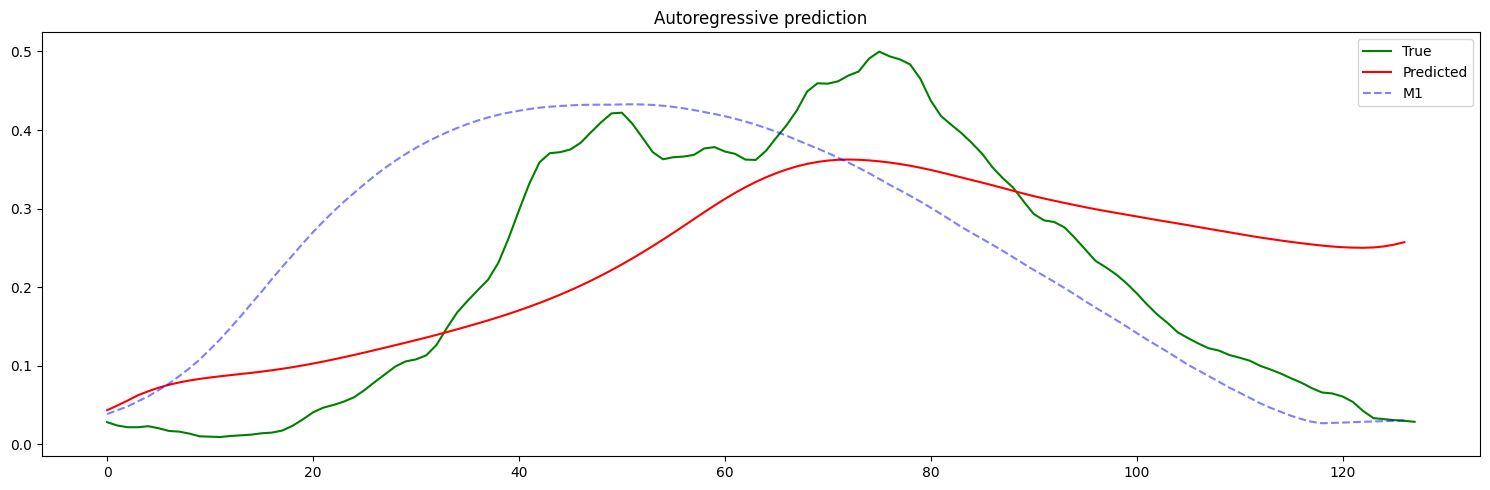

In [13]:
# make autoregressive prediction
preds_auto = model.autoregressive_prediction(test_data_X.to(device))
# plot autoregressive prediction
plt.figure(figsize=(15, 5))
plt.plot(test_data_y, label='True', color='green')
plt.plot(preds_auto, label='Predicted', color='red')
# M1
plt.plot(model_series[-len(preds_auto):], label='M1', linestyle='--', color='blue', alpha=0.5)
plt.title('Autoregressive prediction')
plt.legend()
plt.tight_layout()
plt.show()

In [14]:
l = len(data.y)
date = df['decimal_date'].values[-l:]
true = data.y.numpy()
predicted = np.array(preds.detach().cpu())
M1 = model_series[-l:]
autoregressive = np.zeros(l)
autoregressive[-len(preds_auto):] = preds_auto
print(date.shape, true.shape, predicted.shape, M1.shape, autoregressive.shape)

df_results = pd.DataFrame({'date': date, 'true': true, 'predicted': predicted, 'M1': M1, 'autoregressive': autoregressive})
df_results.tail()

(640,) (640,) (640,) torch.Size([640]) (640,)


,date,true,predicted,M1,autoregressive
635,2018.623,0.033491,0.047549,0.028838,0.250190
636,2018.705,0.032203,0.040864,0.029266,0.250613
637,2018.790,0.030915,0.040137,0.029564,0.251891
638,2018.873,0.030056,0.040741,0.030029,0.254157
639,2018.958,0.028768,0.041153,0.030656,0.257319


In [15]:
# add column delta true-predicted
df_results['delta'] = (df_results['true'] - df_results['predicted']) * M
df_results.tail()

,date,true,predicted,M1,autoregressive,delta
635,2018.623,0.033491,0.047549,0.028838,0.250190,-3.274109
636,2018.705,0.032203,0.040864,0.029266,0.250613,-2.017158
637,2018.790,0.030915,0.040137,0.029564,0.251891,-2.147972
638,2018.873,0.030056,0.040741,0.030029,0.254157,-2.488688
639,2018.958,0.028768,0.041153,0.030656,0.257319,-2.884634


In [16]:
# plt delta and title is rmse of delta

train_delta = df_results['delta'][:len(train_data_X)]
val_delta = df_results['delta'][len(train_data_X):len(train_data_X) + len(val_data_X)]
test_delta = df_results['delta'][-len(test_data_X):]

fig = go.Figure()
fig.add_trace(go.Scatter(x=np.arange(len(train_delta)), y=train_delta, mode='lines', name='Train Delta'))
fig.add_trace(go.Scatter(x=np.arange(len(train_delta), len(train_delta) + len(val_delta)), y=val_delta, mode='lines', name='Validation Delta'))
fig.add_trace(go.Scatter(x=np.arange(len(train_delta) + len(val_delta), len(train_delta) + len(val_delta) + len(test_delta)), y=test_delta, mode='lines', name='Test Delta'))

# title 3 rmse
rmse_train = np.sqrt(np.mean(train_delta**2))
rmse_val = np.sqrt(np.mean(val_delta**2))
rmse_test = np.sqrt(np.mean(test_delta**2))
fig.update_layout(title=f'Train rmse: {rmse_train:.4f}\nValidation rmse: {rmse_val:.4f}\nTest rmse: {rmse_test:.4f}', xaxis_title='Time', yaxis_title='Delta')
fig.show()

## Autoregressive model

In [18]:
steps = 13
# make df with start date, rmse_1, rmse_2, ... rmse_steps
df_rmse = pd.DataFrame(columns=['start_date'] + [f'delta_{i}' for i in range(1, steps + 1)])
for i in range(len(test_data_X) - steps):
    preds_auto = model.autoregressive_prediction(test_data_X[i:].to(device))[:steps]
    target = test_data_y[i:i + steps].numpy()
    delta = (target - preds_auto) * M
    df_rmse.loc[i, 'start_date'] = df['decimal_date'].values[-len(test_data_X) + i]
    df_rmse.loc[i, [f'delta_{i+1}' for i in range(steps)]] = delta


df_rmse.head()

,start_date,delta_1,delta_2,delta_3,delta_4,delta_5,delta_6,delta_7,delta_8,delta_9,delta_10,delta_11,delta_12,delta_13
0,2008.373,-3.53632,-5.936278,-7.913806,-9.471092,-10.357992,-12.003074,-13.671628,-14.563128,-15.742606,-17.019363,-17.532156,-17.995035,-18.038987
1,2008.456,-3.528889,-5.67481,-7.417237,-8.895656,-10.856205,-12.833243,-13.997307,-15.364473,-16.794601,-17.421253,-17.964736,-18.067502,-18.239869
2,2008.54,-3.383524,-5.30887,-6.97517,-9.521222,-11.792796,-13.245638,-14.866129,-16.466526,-17.232362,-17.87847,-18.053271,-18.278353,-18.481479
3,2008.624,-3.156039,-4.990966,-7.706669,-10.530497,-12.252044,-14.138656,-15.973836,-16.896466,-17.672082,-17.943016,-18.236319,-18.490258,-18.529924
4,2008.708,-2.972231,-5.827743,-8.794823,-11.021136,-13.150917,-15.230384,-16.370427,-17.292727,-17.686016,-18.071476,-18.391998,-18.482203,-18.76701


In [19]:
rmses = np.sqrt(np.mean(df_rmse.iloc[:, 1:]**2, axis=0))
rmses

delta_1      2.212843
delta_2      4.080568
delta_3      5.881949
delta_4      7.559642
delta_5      8.936810
delta_6     10.128992
delta_7     11.252477
delta_8     12.419288
delta_9     13.695779
delta_10    15.067762
delta_11    16.454000
delta_12    17.763335
delta_13    18.959148
dtype: float64